# Block Resampling & Z Scores

This code takes in raw climate data from [Met Eireann](http://www.met.ie/climate-request/) then: 
- Computes [Potential Evapotranspiration](https://en.wikipedia.org/wiki/Potential_evaporation) according to the Hargreaves method (chosen due to data availability) 
- Splits the data into seasons according to the climatological year (Winter: DJF, Spring: MAM, Summer: JJA, Autumn: SON)
- Removes seasons which has missing values above a certain threshold
- Calculates temperature and rainfall extremes based on z-scores and standard deviations respectively
- Allows for the selection of certain seasonal characteristics (warm/wet, warm/dry, cold/wet, cold/dry)
- Resamples the observed climate and produces a new sequence which takes extremes into account

### To Do List

TODO:

- Use quantiles or ranks instead of std dev and z scores

- check if extremes are becoming more frequent over time (bar chart with regression line) run a random simulation (1000 possible scenarios), regression line this also, compare extremes (values above x are 10% likelier to occur etc)

- Crude measurement of extremes - average for first 20 years vs average for 2nd 20 years and see the difference (is it warming?)

- use a longer dataset and pull out multi-extreme years (do modern years have higher frequency of extremes?)do the same with multi-extreme years (warm/dry, cold/wet etc)

- Overall:
    - Split into seasons
    - Rank
    - Frequency analysis
    - Choose new sequence

### User-Defined Variables (to be coded in if possible)

In [1]:
outputyears = 50 #number of years in your generated sequence
stddev = 0.75 #number of standard deviations (above and below 0) to calculate extremes

### Load Necessary Packages

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pyeto #install from here (https://github.com/woodcrafty/PyETo), download zip, move to scripts folder in your python
# distribution (/Anaconda/Scripts/PyETo), navigate to this folder in your cmd, type: python setup.py install, restart python
from pyeto import hargreaves
%matplotlib inline

### Read in & display climate data

- maxtp: -  Maximum Air Temperature (C)
- mintp: -  Minimum  Air Temperature (C)
- rain: -	  Precipitation Amount (mm)
- cbl:  -   Mean CBL Pressure (hpa) (CBL - convective boundary layer)
- wdsp: -	  Mean Wind Speed (knot)
- hm: -	  Highest ten minute mean wind speed (knot)		                 
- ddhm: -	  Mean Wind Direction over 10 minutes at time of highest 10 minute mean (degree)                  
- hg: -	  Highest Gust (knot)
- soil  -   Mean 10cm soil temperature (C)
- i: -	  Indicator

Read in met data from different sites 

In [3]:
OakPark = pd.read_csv("E:\PhD\Data\MetData\Raw\dly375 (Oak Park)\dly375.csv",skiprows=16, na_values=[' '])
Valentia = pd.read_csv("E:\PhD\Data\MetData\Valentia\dly2275\dly2275.csv",skiprows=25, na_values=[' '])

In [4]:
df = OakPark #working with Oak Park data here
df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,hm,iddhm,ddhm,ihg,hg,soil
0,01-jan-2007,0,6.1,0,3.6,0,4.8,1005.9,10.7,0,23,0,250,0,33,4.071
1,02-jan-2007,0,9.4,0,4.8,0,0.4,1017.2,11.3,0,21,0,240,0,33,4.304
2,03-jan-2007,0,12.1,0,8.1,0,2.9,1005.7,14.6,0,25,0,250,0,38,7.723
3,04-jan-2007,0,9.7,0,7.3,0,0.0,1004.2,12.8,0,23,0,260,0,35,6.758
4,05-jan-2007,0,10.2,0,4.7,0,0.8,1005.5,9.4,0,14,0,260,0,19,6.760


Convert 'date' column to datetime object

In [5]:
df['date'] = pd.to_datetime(df['date'], format= '%d-%b-%Y') # https://docs.python.org/2/library/datetime.html see end of this page for %d %m %Y

Find start and end year of the data

In [6]:
no_of_years = df['date'].dt.year #creates a variable for the year column
no_of_years = list(no_of_years) #turns it into a list

In [7]:
startyear = no_of_years[0] #gets the first value
print startyear

endyear = no_of_years[-1] #gets the last value
print endyear

2007
2015


### Create mean temp field

In [8]:
df['meantp'] = (df['maxtp'] + df['mintp'])/2
df.meantp = df.meantp.round(1) #keep Tmean to one decimal place as that's what's in the original dat
#NOTE:Numpy rounds to the nearest even value. Thus 1.5 and 2.5 round to 2.0, -0.5 and 0.5 round to 0.0, etc.

### Calculate PET using [Hargreaves method](https://github.com/woodcrafty/PyETo/blob/master/docs/hargreaves.rst) (from [PyETo package](https://github.com/woodcrafty/PyETo))

The hargreaves method is recommended by the FAO (Allen et al, 1998) where insufficient meterological data are available from Penman-Monteith)

It uses temperature and solar radiation which is estimated from the latitude and the time of year.

The Hargreaves equation has a tendency to under-estimate ETo under high wind conditions(u2 > 3m/s) and to over-estimate under conditions of high relative humidity.

**First specify latitude for your site, and create a 'day of year' column from the date:**

In [9]:
lat = pyeto.deg2rad(52.861) #latitude for Oak Park Carlow

df['lat']= lat #add column to the dataframe

df['dayofyear'] = pd.DatetimeIndex(df['date']).dayofyear #create 'day of year' column to calculate sunshine variables

Estimate solar declination (sol_dec), sunset hour angle (sha), inverse relative distance from Earth to the sun (ird), and ET radiation (et_rad)

In [10]:
sol_dec = df['dayofyear'].apply(pyeto.sol_dec)   # Solar declination
df['sol_dec'] = sol_dec #add column

sha = df.apply(lambda x: pyeto.sunset_hour_angle(x['lat'],x['sol_dec']), axis=1)
df['sha'] = sha #add column

ird = df['dayofyear'].apply(pyeto.inv_rel_dist_earth_sun)
df['ird'] = ird

et_rad = df.apply(lambda x: pyeto.et_rad(x['lat'],x['sol_dec'],x['sha'],x['ird']), axis =1)   # Extraterrestrial radiation
df['et_rad'] = et_rad

df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,...,ihg,hg,soil,meantp,lat,dayofyear,sol_dec,sha,ird,et_rad
0,2007-01-01,0,6.1,0,3.6,0,4.8,1005.9,10.7,0,...,0,33,4.071,4.8,0.922598,1,-0.401008,0.976637,1.032995,6.083577
1,2007-01-02,0,9.4,0,4.8,0,0.4,1017.2,11.3,0,...,0,33,4.304,7.1,0.922598,2,-0.399564,0.979348,1.032980,6.134697
2,2007-01-03,0,12.1,0,8.1,0,2.9,1005.7,14.6,0,...,0,38,7.723,10.1,0.922598,3,-0.398001,0.982272,1.032956,6.190089
3,2007-01-04,0,9.7,0,7.3,0,0.0,1004.2,12.8,0,...,0,35,6.758,8.5,0.922598,4,-0.396320,0.985406,1.032922,6.249764
4,2007-01-05,0,10.2,0,4.7,0,0.8,1005.5,9.4,0,...,0,19,6.760,7.4,0.922598,5,-0.394522,0.988748,1.032878,6.313735


Apply the 'hargreaves' function

In [11]:
PEcalc = df.apply(lambda x: hargreaves(x['mintp'], x['maxtp'], x['meantp'], x['et_rad']),axis=1)
df['hargreaves'] = PEcalc #create a column
df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,...,hg,soil,meantp,lat,dayofyear,sol_dec,sha,ird,et_rad,hargreaves
0,2007-01-01,0,6.1,0,3.6,0,4.8,1005.9,10.7,0,...,33,4.071,4.8,0.922598,1,-0.401008,0.976637,1.032995,6.083577,0.203998
1,2007-01-02,0,9.4,0,4.8,0,0.4,1017.2,11.3,0,...,33,4.304,7.1,0.922598,2,-0.399564,0.979348,1.032980,6.134697,0.307439
2,2007-01-03,0,12.1,0,8.1,0,2.9,1005.7,14.6,0,...,38,7.723,10.1,0.922598,3,-0.398001,0.982272,1.032956,6.190089,0.324130
3,2007-01-04,0,9.7,0,7.3,0,0.0,1004.2,12.8,0,...,35,6.758,8.5,0.922598,4,-0.396320,0.985406,1.032922,6.249764,0.238953
4,2007-01-05,0,10.2,0,4.7,0,0.8,1005.5,9.4,0,...,19,6.760,7.4,0.922598,5,-0.394522,0.988748,1.032878,6.313735,0.350152


Compare hargreaves calculation to Met Eireann PE (Penman-Monteith method) (purely to see if the calculation approximates)

In [12]:
metPE = pd.read_excel("E:\PhD\Data\MetData\PE\OakPark 08-16.xlsx")
metPE['date'] = pd.to_datetime(metPE['date'], format= '%d-%b-%Y') #datetime object
metPE = metPE[['date','PE (mm)']]
metPE.head()

,date,PE (mm)
0,2008-01-01,0.546
1,2008-01-02,0.825
2,2008-01-03,0.416
3,2008-01-04,0.390
4,2008-01-05,0.253


Drop 2007 from hargreaves calculation

In [13]:
df2 = df.ix[365:]
df2 = df2[['date','hargreaves']]
df2.head()

,date,hargreaves
365,2008-01-01,0.313550
366,2008-01-02,0.276951
367,2008-01-03,0.265258
368,2008-01-04,0.391506
369,2008-01-05,0.284838


Merge the two dataframes

**Calculate seasonal sums and compare (percentage bias)**

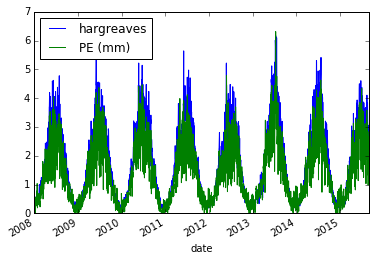

In [14]:
compare = df2.merge(metPE, on = 'date')
compare.head()
compare.plot(x='date')

Filter out unwanted columns (Model only needs temp, PE and rainfall)

In [15]:
df = df[['date','meantp','hargreaves','rain']]
df.head()

,date,meantp,hargreaves,rain
0,2007-01-01,4.8,0.203998,4.8
1,2007-01-02,7.1,0.307439,0.4
2,2007-01-03,10.1,0.324130,2.9
3,2007-01-04,8.5,0.238953,0.0
4,2007-01-05,7.4,0.350152,0.8


Convert 'date' column to datetime object so Pandas can use it 

Split data into seasons based on months

Winter = 1, Spring = 2, Summer = 3, Autumn = 4

In [16]:
#create a season function to split data into seasons
def get_season(row):
    if row['date'].month >= 3 and row['date'].month <= 5:
        return '2'
    elif row['date'].month >= 6 and row['date'].month <= 8:
        return '3'
    elif row['date'].month >= 9 and row['date'].month <= 11:
        return '4'
    else:
        return '1'

Apply the season function to the data

In [17]:
df['Season'] = df.apply(get_season, axis=1)

C:\Users\pflattery\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Create 'Year' column from the 'date' column

In [18]:
df['Year'] = df['date'].dt.year
df.head()

C:\Users\pflattery\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,meantp,hargreaves,rain,Season,Year
0,2007-01-01,4.8,0.203998,4.8,1,2007
1,2007-01-02,7.1,0.307439,0.4,1,2007
2,2007-01-03,10.1,0.324130,2.9,1,2007
3,2007-01-04,8.5,0.238953,0.0,1,2007
4,2007-01-05,7.4,0.350152,0.8,1,2007


Make December of previous year part of winter for current year (to keep climatolgical year) 

In [19]:
#Redefine the year to attach December of previous year to winter of following year 
#Everywhere the month is '12', the year column gets increased by 1. 
df.loc[df['date'].dt.month == 12, 'Year'] += 1
df.head()

C:\Users\pflattery\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\core\indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,date,meantp,hargreaves,rain,Season,Year
0,2007-01-01,4.8,0.203998,4.8,1,2007
1,2007-01-02,7.1,0.307439,0.4,1,2007
2,2007-01-03,10.1,0.324130,2.9,1,2007
3,2007-01-04,8.5,0.238953,0.0,1,2007
4,2007-01-05,7.4,0.350152,0.8,1,2007


Create a new dataframe indexed by Year and Season

In [20]:
#how to multiindex from here: http://stackoverflow.com/questions/33435971/selecting-time-series-data-in-a-specific-sequence-using-pandas/33437422#33437422
df2 = df.set_index(['Year', 'Season'], inplace=False)
df2.head()

date  meantp  hargreaves  rain
Year Season                                     
2007 1      2007-01-01     4.8    0.203998   4.8
     1      2007-01-02     7.1    0.307439   0.4
     1      2007-01-03    10.1    0.324130   2.9
     1      2007-01-04     8.5    0.238953   0.0
     1      2007-01-05     7.4    0.350152   0.8

# Remove incomplete seasons and apply missing value threshold
Count the values in each season (also indicates missing values)

Number of days in:
- 1 (Winter): 90 (91 in Leap Year - how to deal with this?) 
- 2 (Spring): 92
- 3 (Summer): 92
- 4 (Autumn): 91

In [21]:
count = df2.groupby(level=[0, 1]).count()
count

date  meantp  hargreaves  rain
Year Season                                
2007 1         59      59          59    59
     2         92      92          92    92
     3         92      92          92    90
     4         91      91          91    74
2008 1         91      91          91    86
     2         92      92          92    92
     3         92      92          92    91
     4         91      91          91    90
2009 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2010 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2011 1         90      90          90    90
     2         92      92          92    92
     3         92      91          91    91
     4         91      91          91    91
2012 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2013 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    89
     4         91      91          91    91
2014 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2015 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92

Create a 'complete' variable with only complete months of data (75 is completely arbitrary - code this in up top)

In [22]:
complete = count[count['rain'] >= 75].index #counts seasons with more than 75 values for rain

Create an index for the values in the dataframe which match the 'complete' index

In [23]:
idx = df2.index.isin(complete)
idx #first are false, as the first season (Winter 2007) does not have enough days in it (missing December 2006)

array([False, False, False, ...,  True,  True,  True], dtype=bool)

In [24]:
df = df[idx]
df

,date,meantp,hargreaves,rain,Season,Year
59,2007-03-01,5.7,1.062825,0.3,2,2007
60,2007-03-02,3.8,0.988286,16.9,2,2007
61,2007-03-03,7.0,1.187963,0.2,2,2007
62,2007-03-04,7.0,1.241618,10.0,2,2007
63,2007-03-05,6.5,1.163585,14.3,2,2007
64,2007-03-06,6.8,1.069878,5.5,2,2007
65,2007-03-07,6.0,1.206203,0.3,2,2007
66,2007-03-08,5.9,1.149655,4.0,2,2007
67,2007-03-09,7.4,1.281770,0.1,2,2007
68,2007-03-10,9.7,1.447036,0.0,2,2007


In [25]:
df2 = df.set_index(['Year', 'Season'], inplace=False)
df2

date  meantp  hargreaves  rain
Year Season                                     
2007 2      2007-03-01     5.7    1.062825   0.3
     2      2007-03-02     3.8    0.988286  16.9
     2      2007-03-03     7.0    1.187963   0.2
     2      2007-03-04     7.0    1.241618  10.0
     2      2007-03-05     6.5    1.163585  14.3
     2      2007-03-06     6.8    1.069878   5.5
     2      2007-03-07     6.0    1.206203   0.3
     2      2007-03-08     5.9    1.149655   4.0
     2      2007-03-09     7.4    1.281770   0.1
     2      2007-03-10     9.7    1.447036   0.0
     2      2007-03-11     7.6    1.086091   7.3
     2      2007-03-12     7.9    1.363238   1.3
     2      2007-03-13     7.3    1.432536   0.1
     2      2007-03-14     8.2    1.655405   0.1
     2      2007-03-15     6.2    1.501943   0.1
     2      2007-03-16     5.0    1.413379   0.1
     2      2007-03-17    10.0    0.978895   0.2
     2      2007-03-18     5.0    1.341261   1.5
     2      2007-03-19     3.6    1.106303   2.9
     2      2007-03-20     3.6    1.148815   0.0
     2      2007-03-21     1.6    1.280704   2.4
     2      2007-03-22     8.5    1.264217   0.4
     2      2007-03-23     6.3    1.726442   0.0
     2      2007-03-24     6.8    1.867513   0.0
     2      2007-03-25     6.4    1.688401   0.0
     2      2007-03-26     7.0    1.909344   0.0
     2      2007-03-27     6.8    2.191774   0.0
     2      2007-03-28     6.6    1.598351   1.6
     2      2007-03-29     5.9    1.521981   2.5
     2      2007-03-30     7.1    1.304259   0.0
...                ...     ...         ...   ...
2015 3      2015-08-02    15.2    3.070193   8.6
     3      2015-08-03    15.4    2.941266   1.1
     3      2015-08-04    15.6    2.962541   0.5
     3      2015-08-05    14.2    2.394153  10.0
     3      2015-08-06    14.0    3.393655   0.4
     3      2015-08-07    13.7    3.289386   0.0
     3      2015-08-08    12.7    3.529534   0.4
     3      2015-08-09    17.2    2.935915   0.0
     3      2015-08-10    15.2    3.252137   0.1
     3      2015-08-11    15.0    2.753564   0.0
     3      2015-08-12    15.2    3.786022   0.0
     3      2015-08-13    15.6    4.105458   0.0
     3      2015-08-14    13.6    3.116571   0.7
     3      2015-08-15    11.5    3.056900   0.0
     3      2015-08-16    13.6    2.856747   0.0
     3      2015-08-17    16.6    3.030269   0.0
     3      2015-08-18    15.8    3.845087   0.0
     3      2015-08-19    16.6    3.016253   5.2
     3      2015-08-20    16.7    2.754104   0.1
     3      2015-08-21    17.4    3.069284   0.6
     3      2015-08-22    14.7    2.584863   6.0
     3      2015-08-23    13.6    1.398668  11.1
     3      2015-08-24    13.2    3.032389   0.0
     3      2015-08-25    12.5    2.706166  25.4
     3      2015-08-26    13.8    2.535701   4.6
     3      2015-08-27    13.8    2.810942   3.9
     3      2015-08-28    14.0    2.772288   1.1
     3      2015-08-29    15.0    2.816055   2.7
     3      2015-08-30    13.6    2.326787   0.1
     3      2015-08-31    15.0    2.405260   0.4

[3015 rows x 4 columns]

In [26]:
df2['rainrank'] = df2['rain'].rank()
df2['trmprank'] = df2['meantp'].rank()
df2.head()

date  meantp  hargreaves  rain  rainrank  trmprank
Year Season                                                         
2007 2      2007-03-01     5.7    1.062825   0.3    1493.5     628.5
     2      2007-03-02     3.8    0.988286  16.9    2935.5     345.5
     2      2007-03-03     7.0    1.187963   0.2    1404.5     885.5
     2      2007-03-04     7.0    1.241618  10.0    2800.0     885.5
     2      2007-03-05     6.5    1.163585  14.3    2899.0     785.5

Histogram

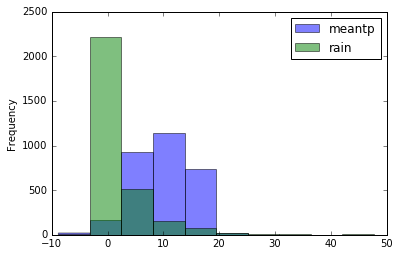

In [27]:
df2[['meantp','rain']].plot.hist(alpha=0.5)

Print the entire dataframe to check it (can remove this section as it does it correctly)

Calculate number of seasons in the dataset (to calculate seasonal rainfall means later)

In [28]:
seascount = df2.groupby(level=[0,1]).count() #counting number of seasons (to divide for avg seasonal rainfall later)
seascount

date  meantp  hargreaves  rain  rainrank  trmprank
Year Season                                                    
2007 2         92      92          92    92        92        92
     3         92      92          92    90        90        92
2008 1         91      91          91    86        86        91
     2         92      92          92    92        92        92
     3         92      92          92    91        91        92
     4         91      91          91    90        90        91
2009 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
2010 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
2011 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      91          91    91        91        91
     4         91      91          91    91        91        91
2012 1         91      91          91    91        91        91
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
2013 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    89        89        92
     4         91      91          91    91        91        91
2014 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
2015 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92

In [29]:
seasoncount = df.reset_index().groupby('Season')['Year'].nunique()
print seasoncount

Season
1    8
2    9
3    9
4    7
Name: Year, dtype: int64


# Temperature Extremes

Calculate mean values for each season

In [30]:
seasmean = df['meantp'].groupby(df['Season']).mean()
print seasmean #check the averages - do they seem correct? Yes

Season
1     4.795568
2     8.845411
3    14.850544
4    10.382732
Name: meantp, dtype: float64


Calculating differences between season and season means & adding a zscore column

In [31]:
df2['seasdif'] = df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean #creates an anomaly column
seasdif = df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean #creates a series

df2['tempzscore'] = (df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean) / df2['meantp'].groupby(level=['Year','Season']).std() #calculates z-scores
tempzscore = (df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean) / df2['meantp'].groupby(level=['Year','Season']).std() #series

print seasdif
print df2.head()

Year  Season
2007  2         0.883937
      3        -0.120109
2008  1         1.298938
      2         0.016546
      3        -0.083153
      4        -0.848666
2009  1        -0.448901
      2         0.174155
      3         0.121195
      4         0.250235
2010  1        -2.391123
      2        -0.442150
      3         0.436412
      4        -0.716797
2011  1        -1.755568
      2         0.729589
      3        -1.162632
      4         1.437049
2012  1         1.635201
      2        -0.054106
      3        -0.245109
      4        -1.199215
2013  1         0.314432
      2        -1.618237
      3         1.232065
      4         0.481005
2014  1         1.128877
      2         0.794807
      3         0.455978
      4         0.596389
2015  1         0.185543
      2        -0.484541
      3        -0.647283
Name: meantp, dtype: float64
                  date  meantp  hargreaves  rain  rainrank  trmprank  \
Year Season                                                  

Visualise the seasonal differences (illustrative only - to get an idea of variation)

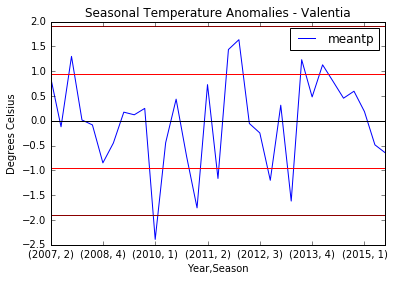

In [32]:
#visualise the seasonal differences (calculate greater than 2 standard deviations?)
seasdif.plot()
plt.axhline(0,color='black')
plt.axhline(seasdif.std() * 1, color ='red')
plt.axhline(-(seasdif.std()) * 1, color ='red')
plt.axhline(seasdif.std() * 2, color ='darkred')
plt.axhline(-(seasdif.std()) * 2, color ='darkred')
plt.title('Seasonal Temperature Anomalies - Valentia')
plt.legend(loc='best') #handy trick
plt.ylabel('Degrees Celsius')
plt.savefig('C:\Users\pflattery\Dropbox\Programming\Jupyter\Python\ValentiaAnomaly2.png', dpi=500) #Save the figure

### Z score comparison

Plot the Z-Score column (two different ways, to see if both methods did the same thing)

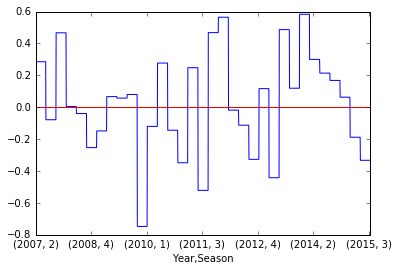

In [33]:
df2['tempzscore'].plot()
plt.axhline(0, color ='red')

In [34]:
seaszscore = (df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean) / df2['meantp'].groupby(level=['Year','Season']).std()
seaszscore = pd.DataFrame(seaszscore)
seaszscore

meantp
Year Season          
2007 2       0.285487
     3      -0.078255
2008 1       0.466904
     2       0.004817
     3      -0.039394
     4      -0.253130
2009 1      -0.148388
     2       0.066754
     3       0.057498
     4       0.080213
2010 1      -0.747489
     2      -0.119875
     3       0.277255
     4      -0.144012
2011 1      -0.348149
     2       0.247973
     3      -0.521351
     4       0.468077
2012 1       0.564761
     2      -0.017981
     3      -0.112629
     4      -0.326642
2013 1       0.116867
     2      -0.442007
     3       0.487095
     4       0.119518
2014 1       0.583180
     2       0.300093
     3       0.214225
     4       0.168300
2015 1       0.063110
     2      -0.187967
     3      -0.332652

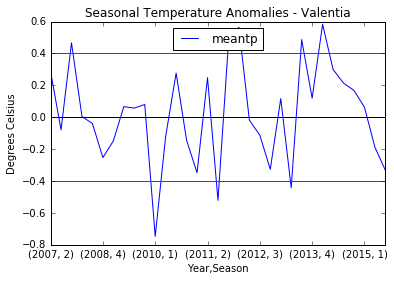

In [35]:
seaszscore.plot()
plt.axhline(0,color='black')
plt.axhline(0.4, color ='red')
plt.axhline(-0.4, color ='red')
plt.title('Seasonal Temperature Anomalies - Valentia')
plt.legend(loc='upper center') #handy trick
plt.ylabel('Degrees Celsius')
plt.savefig('ValentiaAnomaly.png', dpi=500) #Save the figure

Histogram

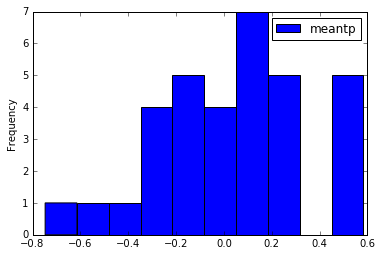

In [36]:
seaszscore.plot.hist()

# Rainfall Extremes

Calculate sum values for each season

In [37]:
rainsum = df['rain'].groupby(df['Season']).sum() / seasoncount #seasonal sums divided by number of years to get baseline rainfall
print rainsum #checked this in Excel, the division is correct

Season
1    223.487500
2    153.155556
3    248.788889
4    267.100000
dtype: float64


In [38]:
raindif = df2['rain'].groupby(level=['Year','Season']).sum() - rainsum #work out the anomalies
raindif

Year  Season
2007  2         -26.355556
      3          85.611111
2008  1          14.712500
      2          -0.355556
      3         117.111111
      4         -51.200000
2009  1         -33.087500
      2          50.844444
      3          69.911111
      4         118.100000
2010  1         -30.287500
      2          27.944444
      3         -91.988889
      4          -1.800000
2011  1           1.212500
      2         -66.955556
      3        -104.188889
      4           9.900000
2012  1         -72.687500
      2         -28.655556
      3         117.711111
      4         -84.900000
2013  1         -43.387500
      2         -15.555556
      3         -97.288889
      4         -45.000000
2014  1         237.012500
      2          43.044444
      3         -40.188889
      4          54.900000
2015  1         -73.487500
      2          16.044444
      3         -56.688889
dtype: float64

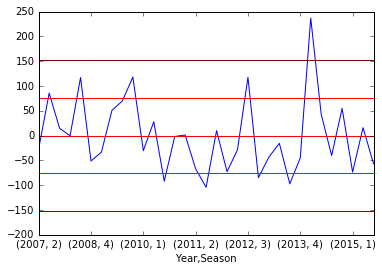

In [39]:
#visualise the seasonal differences - does this method make sense?
raindif.plot()
plt.axhline(0,color='red')
plt.axhline(raindif.std() * 1, color ='red')
plt.axhline(-(raindif.std()) * 1, color ='red')
plt.axhline(raindif.std() * 2, color ='darkred')
plt.axhline(-(raindif.std()) * 2, color ='darkred')

# Extracting extreme seasons

Create a copy of the dataframe and two blank lists for hot and cold extremes

In [40]:
seasdif2 = pd.DataFrame(seasdif)
warm = []
cold = []

Create a function which identifies warm and cold extremes based on the data

Currently uses 1 standard deviation as the threshold, could use a z-score?

In [41]:
def extremetemp(x):
    for season in x:
        if season > x.std() * stddev:
            warm.append(1)
        else:
            warm.append(0)

    for season in x:
        if season < (-(x.std()*stddev)):
            cold.append(1)
        else:
            cold.append(0)

Apply the function to the dataset

In [42]:
extremetemp(seasdif)

Create new columns in duplicate dataset to identify which season has an extreme value

In [43]:
seasdif2['cold']=cold
seasdif2['warm']=warm
seasdif2

meantp  cold  warm
Year Season                      
2007 2       0.883937     0     1
     3      -0.120109     0     0
2008 1       1.298938     0     1
     2       0.016546     0     0
     3      -0.083153     0     0
     4      -0.848666     1     0
2009 1      -0.448901     0     0
     2       0.174155     0     0
     3       0.121195     0     0
     4       0.250235     0     0
2010 1      -2.391123     1     0
     2      -0.442150     0     0
     3       0.436412     0     0
     4      -0.716797     1     0
2011 1      -1.755568     1     0
     2       0.729589     0     1
     3      -1.162632     1     0
     4       1.437049     0     1
2012 1       1.635201     0     1
     2      -0.054106     0     0
     3      -0.245109     0     0
     4      -1.199215     1     0
2013 1       0.314432     0     0
     2      -1.618237     1     0
     3       1.232065     0     1
     4       0.481005     0     0
2014 1       1.128877     0     1
     2       0.794807     0     1
     3       0.455978     0     0
     4       0.596389     0     0
2015 1       0.185543     0     0
     2      -0.484541     0     0
     3      -0.647283     0     0

### Do the same for Rainfall

In [44]:
raindif2 = pd.DataFrame(raindif)
wet = []
dry = []

Create a function which identifies wet and dry extremes based on the data

In [45]:
def extremerain(x):
    for season in x:
        if season > x.std() * stddev:
            wet.append(1)
        else:
            wet.append(0)

    for season in x:
        if season < (-(x.std()* stddev)):
            dry.append(1)
        else:
            dry.append(0)

Apply the function to the dataset

In [46]:
extremerain(raindif)

In [47]:
seasdif2['wet']=wet
seasdif2['dry']=dry
seasdif2

meantp  cold  warm  wet  dry
Year Season                                
2007 2       0.883937     0     1    0    0
     3      -0.120109     0     0    1    0
2008 1       1.298938     0     1    0    0
     2       0.016546     0     0    0    0
     3      -0.083153     0     0    1    0
     4      -0.848666     1     0    0    0
2009 1      -0.448901     0     0    0    0
     2       0.174155     0     0    0    0
     3       0.121195     0     0    1    0
     4       0.250235     0     0    1    0
2010 1      -2.391123     1     0    0    0
     2      -0.442150     0     0    0    0
     3       0.436412     0     0    0    1
     4      -0.716797     1     0    0    0
2011 1      -1.755568     1     0    0    0
     2       0.729589     0     1    0    1
     3      -1.162632     1     0    0    1
     4       1.437049     0     1    0    0
2012 1       1.635201     0     1    0    1
     2      -0.054106     0     0    0    0
     3      -0.245109     0     0    1    0
     4      -1.199215     1     0    0    1
2013 1       0.314432     0     0    0    0
     2      -1.618237     1     0    0    0
     3       1.232065     0     1    0    1
     4       0.481005     0     0    0    0
2014 1       1.128877     0     1    1    0
     2       0.794807     0     1    0    0
     3       0.455978     0     0    0    0
     4       0.596389     0     0    0    0
2015 1       0.185543     0     0    0    1
     2      -0.484541     0     0    0    0
     3      -0.647283     0     0    0    0

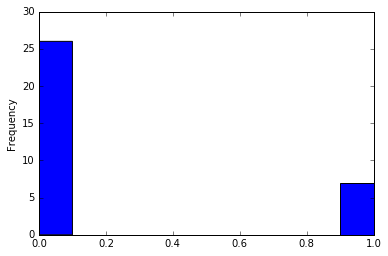

In [48]:
seasdif2['cold'].plot.hist()

### Select out combinations of extremes (warm/wet, warm/dry, cold/wet, cold/dry)

In [49]:
#identify columns with cold extremes (could do the same for warm but there are none)
seasdif2.loc[(seasdif2.cold==1) | (seasdif2.dry==1) | (seasdif2.warm==1) | (seasdif2.wet ==1)]

meantp  cold  warm  wet  dry
Year Season                                
2007 2       0.883937     0     1    0    0
     3      -0.120109     0     0    1    0
2008 1       1.298938     0     1    0    0
     3      -0.083153     0     0    1    0
     4      -0.848666     1     0    0    0
2009 3       0.121195     0     0    1    0
     4       0.250235     0     0    1    0
2010 1      -2.391123     1     0    0    0
     3       0.436412     0     0    0    1
     4      -0.716797     1     0    0    0
2011 1      -1.755568     1     0    0    0
     2       0.729589     0     1    0    1
     3      -1.162632     1     0    0    1
     4       1.437049     0     1    0    0
2012 1       1.635201     0     1    0    1
     3      -0.245109     0     0    1    0
     4      -1.199215     1     0    0    1
2013 2      -1.618237     1     0    0    0
     3       1.232065     0     1    0    1
2014 1       1.128877     0     1    1    0
     2       0.794807     0     1    0    0
2015 1       0.185543     0     0    0    1

Create new index for extremes

In [50]:
df2.index.tolist()

[(2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '2'),
 (2007L, '

Count extreme values in each year

In [51]:
extremecount = seasdif2.groupby(level=[0]).sum()
extremecount

,meantp,cold,warm,wet,dry
Year,,,,,
2007,0.763828,0,1,1,0
2008,0.383665,1,1,1,0
2009,0.096684,0,0,2,0
2010,-3.113658,2,0,0,1
2011,-0.751562,2,2,0,2
2012,0.136771,1,1,1,2
2013,0.409265,1,1,0,1
2014,2.976050,0,2,1,0
2015,-0.946281,0,0,0,1


OLS regression on this data

Plot frequency of extremes

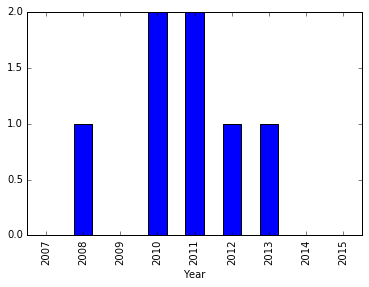

In [52]:
extremecount['cold'].plot(kind='bar')

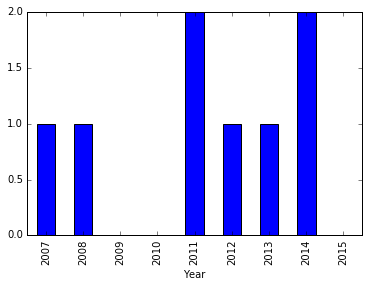

In [53]:
extremecount['warm'].plot(kind='bar')

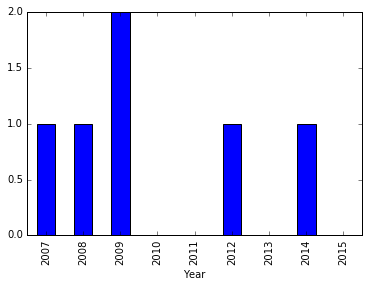

In [54]:
extremecount['wet'].plot(kind='bar')

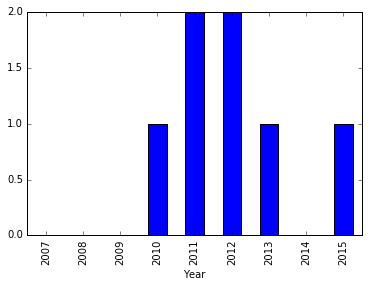

In [55]:
extremecount['dry'].plot(kind='bar')

warm/wet

In [56]:
seasdif2.loc[(seasdif2.warm==1) & (seasdif2.wet ==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,
2014,1,1.128877,0,1,1,0


warm/dry

In [57]:
seasdif2.loc[(seasdif2.warm==1) & (seasdif2.dry ==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,
2011,2,0.729589,0,1,0,1
2012,1,1.635201,0,1,0,1
2013,3,1.232065,0,1,0,1


cold/dry

In [58]:
seasdif2.loc[(seasdif2.cold==1) & (seasdif2.dry==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,
2011,3,-1.162632,1,0,0,1
2012,4,-1.199215,1,0,0,1


cold/wet

In [59]:
seasdif2.loc[(seasdif2.cold==1) & (seasdif2.wet ==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,


### Create new extreme dataframes

In [60]:
#cold
extremecold = seasdif2.loc[(seasdif2.cold==1)]

#hot
extremehot = seasdif2.loc[(seasdif2.warm==1)]

#dry
extremedry = seasdif2.loc[(seasdif2.dry==1)]

#wet
extremewet = seasdif2.loc[(seasdif2.wet==1)]

#cold-dry
colddry = seasdif2.loc[(seasdif2.cold==1) & (seasdif2.dry==1)]

#cold-wet
coldwet = seasdif2.loc[(seasdif2.cold==1) & (seasdif2.wet ==1)]

#hot-dry
hotdry = seasdif2.loc[(seasdif2.warm==1) & (seasdif2.dry ==1)]

#hot-wet
hotwet = seasdif2.loc[(seasdif2.warm==1) & (seasdif2.wet ==1)]

#normal
normal = seasdif2.loc[(seasdif2.cold == 0) & (seasdif2.warm==0) & (seasdif2.dry==0) & (seasdif2.wet==0)]

#test (combos of temp and rain don't have one for each season)
normal

meantp  cold  warm  wet  dry
Year Season                                
2008 2       0.016546     0     0    0    0
2009 1      -0.448901     0     0    0    0
     2       0.174155     0     0    0    0
2010 2      -0.442150     0     0    0    0
2012 2      -0.054106     0     0    0    0
2013 1       0.314432     0     0    0    0
     4       0.481005     0     0    0    0
2014 3       0.455978     0     0    0    0
     4       0.596389     0     0    0    0
2015 2      -0.484541     0     0    0    0
     3      -0.647283     0     0    0    0

**Get the index to re-index the dataframes**

In [61]:
#cold
coldindex = extremecold.index.tolist()

#hot
hotindex = extremehot.index.tolist()

#dry
dryindex = extremedry.index.tolist()

#wet
wetindex = extremewet.index.tolist()

#cold-dry
colddryindex = colddry.index.tolist()

#cold-wet
coldwetindex= coldwet.index.tolist()

#hot-dry
hotdryindex = hotdry.index.tolist()

#hot-wet
hotwetindex = hotwet.index.tolist()

#normal
normalindex = normal.index.tolist()

#test
normalindex

[(2008L, '2'),
 (2009L, '1'),
 (2009L, '2'),
 (2010L, '2'),
 (2012L, '2'),
 (2013L, '1'),
 (2013L, '4'),
 (2014L, '3'),
 (2014L, '4'),
 (2015L, '2'),
 (2015L, '3')]

In [62]:
#sum the extreme indices then drop them
extremeindices = coldindex + hotindex + dryindex + wetindex + colddryindex + coldwetindex + hotdryindex + hotwetindex 

### Separate years into seasons for each extreme

In [63]:
#Cold years
coldsample = [[],[],[],[]] #empty list of lists
for (yr,se) in coldindex: 
    coldsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]
coldsample

#hot years
hotsample = [[],[],[],[]] #empty list of lists
for (yr,se) in hotindex: 
    hotsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]

#dry years
drysample = [[],[],[],[]] #empty list of lists
for (yr,se) in dryindex: 
    drysample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]

#wet years
wetsample = [[],[],[],[]] #empty list of lists
for (yr,se) in wetindex: 
    wetsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]

#cold-dry years
colddrysample = [[],[],[],[]] #empty list of lists
for (yr,se) in colddryindex: 
    colddrysample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]

#hot-dry years
hotdrysample = [[],[],[],[]] #empty list of lists
for (yr,se) in hotdryindex: 
    hotdrysample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]
    
#hot-wet years
hotwetsample = [[],[],[],[]] #empty list of lists
for (yr,se) in hotwetindex: 
    hotwetsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]

#cold-wet years
coldwetsample = [[],[],[],[]] #empty list of lists
for (yr,se) in coldwetindex: 
    coldwetsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]
    
#normal years
normalsample = [[],[],[],[]] #empty list of lists
for (yr,se) in normalindex: 
    normalsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]
    
#test
normalsample

[[2009L, 2013L],
 [2008L, 2009L, 2010L, 2012L, 2015L],
 [2014L, 2015L],
 [2013L, 2014L]]

### Generate index for a random year (random 1,2,3,4) for extreme seasons

**WARNING: THIS ONLY WORKS WHEN THERE ARE FULL EXTREME YEARS (extreme winter, spring, summer, autumn)** and prints an error otherwise

In [64]:
#cold years 
cold_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
coldseq = [] #blank list
try:
    for yrlist in coldsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        cold_ctr += 1 # increment cold_ctr variable by 1
        coldseq += [(ran_yr[0], cold_ctr)] #populate coldseq with a random year and a random season (in order)
except:
    print('coldseq (cold extremes) does not have enough extreme data for a full year, it contains: ' + str(coldsample))

################################################################################################################################
#hot years 
hot_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
hotseq = [] #blank list
try:    
    for yrlist in hotsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        hot_ctr += 1 # increment counter variable by 1
        hotseq += [(ran_yr[0], hot_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('hotseq (hot extremes) does not have enough extreme data for a full year, it contains: ' + str(hotsample))

################################################################################################################################
#dry years
dry_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
dryseq = [] #blank list
try:
    for yrlist in drysample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        dry_ctr += 1 # increment counter variable by 1
        dryseq += [(ran_yr[0], dry_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('dryseq (dry extremes) does not have enough extreme data for a full year, it contains: '  + str(drysample))

################################################################################################################################
#wet years
wet_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
wetseq = [] #blank list
try:
    for yrlist in wetsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        wet_ctr += 1 # increment counter variable by 1
        wetseq += [(ran_yr[0], wet_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('wetseq (wet extremes) does not have enough extreme data for a full year, it contains: '  + str(wetsample))

################################################################################################################################
#cold-dry years
colddry_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
colddryseq = [] #blank list
try:
    for yrlist in colddrysample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        colddry_ctr += 1 # increment counter variable by 1
        colddryseq += [(ran_yr[0], colddry_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('colddryseq (colddry extremes) does not have enough extreme data for a full year, it contains: '  + str(colddrysample))
################################################################################################################################
#hot-dry years
hotdry_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
hotdryseq = [] #blank list
try:
    for yrlist in hotdrysample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        hotdry_ctr += 1 # increment counter variable by 1
        hotdryseq += [(ran_yr[0], hotdry_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('hotdryseq (hotdry extremes) does not have enough extreme data for a full year, it contains: '  + str(hotdrysample))

################################################################################################################################
#cold-wet years
coldwet_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
coldwetseq = [] #blank list
try:
    for yrlist in coldwetsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        coldwet_ctr += 1 # increment counter variable by 1
        coldwetseq += [(ran_yr[0], coldwet_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('coldwetseq (coldwet extremes) does not have enough extreme data for a full year, it contains: ' + str(coldwetsample))
################################################################################################################################
#hot-wet years
hotwet_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
hotwetseq = [] #blank list
try:
    for yrlist in hotwetsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        hotwet_ctr += 1 # increment counter variable by 1
        hotwetseq += [(ran_yr[0], hotwet_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('hotwetseq (hotwet extremes) does not have enough extreme data for a full year, it contains: ' + str(hotwetsample))
    
################################################################################################################################
#Normal years
normal_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
normalseq = [] #blank list
try:
    for yrlist in normalsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        normal_ctr += 1 # increment counter variable by 1
        normalseq += [(ran_yr[0], normal_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('normalseq (non-extreme data) does not have enough data for a full year, it contains: ' + str(normalsample))

wetseq (wet extremes) does not have enough extreme data for a full year, it contains: [[2014L], [], [2007L, 2008L, 2009L, 2012L], [2009L]]
colddryseq (colddry extremes) does not have enough extreme data for a full year, it contains: [[], [], [2011L], [2012L]]
hotdryseq (hotdry extremes) does not have enough extreme data for a full year, it contains: [[2012L], [2011L], [2013L], []]
coldwetseq (coldwet extremes) does not have enough extreme data for a full year, it contains: [[], [], [], []]
hotwetseq (hotwet extremes) does not have enough extreme data for a full year, it contains: [[2014L], [], [], []]


**reindex the dataframes**

In [65]:
# This is no longer necessary as the above code makes it redundant 
#Create a variable to select from for non extreme (or 'normal') years
#normalyearindex = normalyears['date'].dt.year #creates a variable for the year column
#normalyearindex = list(normalyearindex) #turns it into a list
#normalyearindex

In [66]:
#cold
extremecold = df2.loc[coldindex]

#hot
extremehot = df2.loc[hotindex]

#dry
dry = df2.loc[dryindex]

#wet
wet = df2.loc[wetindex]

#cold-dry
colddry = df2.loc[colddryindex]

#cold-wet
#coldwet = df2.loc[coldwetindex] #commented out as there is no coldwet combo for Oak Park

#hot-dry
hotdry = df2.loc[hotdryindex]

#hot-wet
hotwet = df2.loc[hotwetindex]

#nomal
normal = df2.loc[normalindex]

#test view
extremehot

date  meantp  hargreaves  rain  rainrank  trmprank  \
Year Season                                                            
2007 2      2007-03-01     5.7    1.062825   0.3    1493.5     628.5   
     2      2007-03-02     3.8    0.988286  16.9    2935.5     345.5   
     2      2007-03-03     7.0    1.187963   0.2    1404.5     885.5   
     2      2007-03-04     7.0    1.241618  10.0    2800.0     885.5   
     2      2007-03-05     6.5    1.163585  14.3    2899.0     785.5   
     2      2007-03-06     6.8    1.069878   5.5    2569.5     848.5   
     2      2007-03-07     6.0    1.206203   0.3    1493.5     688.0   
     2      2007-03-08     5.9    1.149655   4.0    2429.0     665.5   
     2      2007-03-09     7.4    1.281770   0.1    1236.0     973.5   
     2      2007-03-10     9.7    1.447036   0.0     560.0    1427.0   
     2      2007-03-11     7.6    1.086091   7.3    2693.0    1014.0   
     2      2007-03-12     7.9    1.363238   1.3    1956.5    1071.0   
     2      2007-03-13     7.3    1.432536   0.1    1236.0     954.0   
     2      2007-03-14     8.2    1.655405   0.1    1236.0    1128.5   
     2      2007-03-15     6.2    1.501943   0.1    1236.0     724.5   
     2      2007-03-16     5.0    1.413379   0.1    1236.0     503.5   
     2      2007-03-17    10.0    0.978895   0.2    1404.5    1493.0   
     2      2007-03-18     5.0    1.341261   1.5    2006.5     503.5   
     2      2007-03-19     3.6    1.106303   2.9    2296.0     320.5   
     2      2007-03-20     3.6    1.148815   0.0     560.0     320.5   
     2      2007-03-21     1.6    1.280704   2.4    2207.5     137.0   
     2      2007-03-22     8.5    1.264217   0.4    1565.5    1183.5   
     2      2007-03-23     6.3    1.726442   0.0     560.0     739.0   
     2      2007-03-24     6.8    1.867513   0.0     560.0     848.5   
     2      2007-03-25     6.4    1.688401   0.0     560.0     761.0   
     2      2007-03-26     7.0    1.909344   0.0     560.0     885.5   
     2      2007-03-27     6.8    2.191774   0.0     560.0     848.5   
     2      2007-03-28     6.6    1.598351   1.6    2033.0     810.0   
     2      2007-03-29     5.9    1.521981   2.5    2227.5     665.5   
     2      2007-03-30     7.1    1.304259   0.0     560.0     905.0   
...                ...     ...         ...   ...       ...       ...   
2014 2      2014-05-02    10.5    2.086486   0.0     560.0    1589.0   
     2      2014-05-03    10.6    2.251261   1.0    1854.0    1608.0   
     2      2014-05-04    10.7    1.650194   0.0     560.0    1629.0   
     2      2014-05-05    11.2    2.390539   3.2    2334.5    1736.5   
     2      2014-05-06     9.6    2.768818   3.2    2334.5    1406.0   
     2      2014-05-07    10.7    2.495896   0.6    1686.5    1629.0   
     2      2014-05-08    12.4    2.836889  12.1    2857.5    1960.0   
     2      2014-05-09    11.6    2.626150   4.2    2450.0    1814.5   
     2      2014-05-10    11.4    2.377190   3.5    2370.0    1767.5   
     2      2014-05-11    10.5    2.296059   0.6    1686.5    1589.0   
     2      2014-05-12     9.2    2.630538   4.2    2450.0    1330.5   
     2      2014-05-13    11.1    3.258404   1.3    1956.5    1714.0   
     2      2014-05-14    11.2    2.947267   0.0     560.0    1736.5   
     2      2014-05-15    14.7    3.360326   0.0     560.0    2484.5   
     2      2014-05-16    13.8    3.791708   0.0     560.0    2275.5   
     2      2014-05-17    13.0    4.062179   0.0     560.0    2095.0   
     2      2014-05-18    11.5    2.173713  13.0    2870.0    1792.5   
     2      2014-05-19    13.2    3.168666   4.0    2429.0    2139.5   
     2      2014-05-20    13.7    3.565136   2.3    2188.5    2250.0   
     2      2014-05-21    12.1    3.604783   0.1    1236.0    1909.5   
     2      2014-05-22    10.3    2.964240   0.0     560.0    1556.0   
     2      2014-05-23    10.4    2.111947   1.8    2084.0    1574.0   
     2      2014-05-24    11.4    2.847929   8.5    2742.0

**Keep important columns**

In [67]:
#cold
extremecold = extremecold[['meantp','hargreaves','rain']]

#hot
extremehot = extremehot[['meantp','hargreaves','rain']]

#dry
extremedry = dry[['meantp','hargreaves','rain']]

#wet
extremewet = wet[['meantp','hargreaves','rain']]

#cold-dry
colddry = colddry[['meantp','hargreaves','rain']]

#cold-wet
#coldwet = coldwet[['meantp','hargreaves','rain']] #no cold & wet for Oak Park so it's commented out

#hot-dry
hotdry = hotdry[['meantp','hargreaves','rain']]

#hot-wet
hotwet = hotwet[['meantp','hargreaves','rain']]

#normal 
normal = normal[['meantp','hargreaves','rain']]

#test
normal


meantp  hargreaves  rain
Year Season                          
2008 2          9.0    1.174631   0.9
     2          6.0    1.146377   0.6
     2          2.9    0.736657   1.9
     2          5.9    1.057942   0.1
     2          6.6    0.952683   0.0
     2          7.2    1.072043   2.7
     2          5.8    1.144804   1.0
     2          8.0    1.263967   1.8
     2          4.4    1.053900   3.4
     2          5.0    1.009746  10.8
     2          7.4    1.400404   2.5
     2          6.5    1.138518   2.2
     2          7.5    1.367524   0.9
     2          5.4    1.036458   0.0
     2          8.8    0.662900   6.8
     2          5.4    1.312332   2.9
     2          4.3    1.460441   0.0
     2          4.1    1.468544   0.0
     2          4.4    1.531547   0.0
     2          7.2    1.526653   0.0
     2          6.2    1.495312   1.6
     2          4.4    1.252603   0.0
     2          5.4    1.356515   0.2
     2          5.9    1.343114   3.9
     2          5.0    1.785632   0.0
     2          6.4    1.472921   0.6
     2          5.1    1.802008   1.7
     2          7.0    1.592622   8.2
     2          6.5    1.837174   4.9
     2          6.6    1.573926  18.3
...             ...         ...   ...
2015 3         15.2    3.070193   8.6
     3         15.4    2.941266   1.1
     3         15.6    2.962541   0.5
     3         14.2    2.394153  10.0
     3         14.0    3.393655   0.4
     3         13.7    3.289386   0.0
     3         12.7    3.529534   0.4
     3         17.2    2.935915   0.0
     3         15.2    3.252137   0.1
     3         15.0    2.753564   0.0
     3         15.2    3.786022   0.0
     3         15.6    4.105458   0.0
     3         13.6    3.116571   0.7
     3         11.5    3.056900   0.0
     3         13.6    2.856747   0.0
     3         16.6    3.030269   0.0
     3         15.8    3.845087   0.0
     3         16.6    3.016253   5.2
     3         16.7    2.754104   0.1
     3         17.4    3.069284   0.6
     3         14.7    2.584863   6.0
     3         13.6    1.398668  11.1
     3         13.2    3.032389   0.0
     3         12.5    2.706166  25.4
     3         13.8    2.535701   4.6
     3         13.8    2.810942   3.9
     3         14.0    2.772288   1.1
     3         15.0    2.816055   2.7
     3         13.6    2.326787   0.1
     3         15.0    2.405260   0.4

[1006 rows x 3 columns]

### Resample the data and create a new sequence

In [68]:
df3 = df2[['meantp','hargreaves','rain']]
df3.head()

meantp  hargreaves  rain
Year Season                          
2007 2          5.7    1.062825   0.3
     2          3.8    0.988286  16.9
     2          7.0    1.187963   0.2
     2          7.0    1.241618  10.0
     2          6.5    1.163585  14.3

In [69]:
#this code did not function correctly but you're keeping it in case you need it in future
#x years of normal
#for i in range(5):
    #dfs2.append(winters.query("Year == %d"  %np.random.choice(normalyearindex, 1))) #normal year index is an index with extremes dropped
    #dfs2.append(springs.query("Year == %d"  %np.random.choice(normalyearindex, 1)))
    #dfs2.append(summers.query("Year == %d"  %np.random.choice(normalyearindex, 1)))
    #dfs2.append(autumns.query("Year == %d"  %np.random.choice(normalyearindex, 1)))

**Select seasons from each dataframe in sequence**

In [70]:
dfs2 = []
#x years of normal
for i in range (5): #change the number here to change the number of output years
    for item in normalseq: #item is a tuple with year and season, normalseq is all non-extreme year and season pairs 
        dfs2.append(normal.query("Year == %d and Season == '%d'" % item))
    
#follow with x year of extreme cold
for i in range (2): #change the number here to change the number of output years
    for item in coldseq: #item is a tuple with year and season, coldseq is all extreme cold year and season pairs 
        dfs2.append(extremecold.query("Year == %d and Season == '%d'" % item))
    
#follow with x years of extreme hot
for i in range (2): #change the number here to change the number of output years
    for item in hotseq: #item is a tuple with year and season, hotseq is all extreme hot year and season pairs 
        dfs2.append(extremehot.query("Year == %d and Season == '%d'" % item))
        
#follow with x years of extreme dry
for i in range (2): #change the number here to change the number of output years
    for item in dryseq: #item is a tuple with year and season, dryseq is all extreme hot year and season pairs 
        dfs2.append(extremedry.query("Year == %d and Season == '%d'" % item))
        
#follow with x years of extreme wet
#for i in range (2): #change the number here to change the number of output years
    #for item in wetseq: #item is a tuple with year and season, wetseq is all extreme hot year and season pairs 
        #dfs2.append(extremewet.query("Year == %d and Season == '%d'" % item))

#join the dfs (concatenate)
rnd2 = pd.concat(dfs2)
print rnd2    

os.chdir('E:\PhD\Data\Block Resampling')

rnd2.to_csv('test.csv', sep = ',')

             meantp  hargreaves  rain
Year Season                          
2013 1          3.1    0.322884   0.2
     1          5.2    0.425637   6.2
     1          6.4    0.392962   1.8
     1          4.2    0.299152   0.5
     1          1.4    0.290625   0.2
     1          2.8    0.345875   4.2
     1          3.6    0.336541   0.3
     1          2.4    0.369246   0.0
     1          5.2    0.318476   0.0
     1         -0.2    0.227475   0.0
     1          0.5    0.295918   0.0
     1          3.0    0.255465   0.4
     1          2.3    0.289405   0.6
     1          7.4    0.280566   5.8
     1          6.8    0.304407   0.1
     1          5.9    0.332700   2.0
     1          6.6    0.279098   2.3
     1          5.1    0.270360   0.0
     1          8.4    0.281594   5.2
     1          6.8    0.174579   1.1
     1          4.5    0.321398   1.7
     1         10.8    0.372531   7.8
     1          8.6    0.405748   0.2
     1          7.4    0.286591   2.1
     1      

In [71]:
#code testing
sampledf = []
for item in coldseq:
    sampledf.append(extremecold.query("Year == %d and Season == '%d'" % item))
sampledf

[             meantp  hargreaves  rain
 Year Season                          
 2010 1          3.2    0.430541   5.2
      1          6.2    0.359002   9.8
      1          4.4    0.296619   0.5
      1          4.9    0.441162  13.6
      1          8.6    0.385124   9.2
      1          6.0    0.288606   0.5
      1          5.8    0.293227   5.4
      1          7.4    0.431707   3.4
      1          8.0    0.350835   3.9
      1          5.1    0.363850   0.2
      1          6.4    0.327199   0.0
      1          4.2    0.308087   0.0
      1          0.6    0.225988   0.0
      1          2.4    0.301348   0.3
      1          4.6    0.291464   1.3
      1          4.1    0.239998   1.1
      1          2.4    0.244333   0.3
      1         -0.9    0.169928   0.1
      1          0.4    0.285541   2.1
      1          0.2    0.198360   0.0
      1         -1.0    0.193976   0.0
      1         -0.8    0.219146   0.0
      1         -2.0    0.209383   0.0
      1         -1.4    0

In [72]:
#code loop testing
dfs3 = []
for i in range(10):
    dfs3.append(extremecold.query("Season == '1'"  %np.random.choice(no_of_years,1)))
    dfs3.append(extremecold.query("Season == '2'"  %np.random.choice(no_of_years,1)))
    dfs3.append(extremecold.query("Season == '3'"  %np.random.choice(no_of_years,1)))
    dfs3.append(extremecold.query("Season == '4'"  %np.random.choice(no_of_years,1)))    
    
test = pd.concat(dfs3)

os.chdir('E:\PhD\Data\Block Resampling')

test.to_csv('test1.csv', sep = ',')